# **CHANGE LOG**:

In [1]:
# changing input pic default dimension to 400x400
# adding FGVC7 data
# changed the threshold to -0.2

In [2]:
import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset,Subset
from torchvision import transforms,models,datasets
import torch
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split,WeightedRandomSampler
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix
import cv2
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
import seaborn as sns
import itertools
from tqdm import tqdm
#import tensorflow as tf
#import tensorflow_hub as hub
import shutil
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer
#from torchsummary import summary

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
select_machine = 1
#select_machine = int(input("1 : local machine\n2 : colab\n3 : kaggle\n"))

In [4]:
if select_machine == 1:
    train_image_path = 'C:\Local Machine\plant-pathology-2020-fgvc-resized-combined/train_images'
    test_image_path = 'C:\Local Machine\plant-pathology-2020-fgvc-resized-combined/test_images'
    train_df_path = 'C:\Local Machine\plant-pathology-2020-fgvc-resized-combined/train_combined.csv'
    test_df_path = 'C:\Local Machine\plant-pathology-2020-fgvc-resized-combined/sample_submission.csv'
if select_machine == 2:
    train_image_path = '../input/plant-pathology-fgvc8-resized-images/train_images/train_images'
    test_image_path = '../input/plant-pathology-fgvc8-resized-images/test_images'
    train_df_path = '../input/plant-pathology-fgvc8-resized-images/train.csv'
    test_df_path = '../input/plant-pathology-fgvc8-resized-images/sample_submission.csv'
if select_machine == 3:
    train_image_path = '../input/plant-pathology-fgvc8-resized-images/train_images/train_images'
    test_image_path = '../input/plant-pathology-fgvc8-resized-images/test_images'
    train_df_path = '../input/plant-pathology-fgvc8-resized-images/train.csv'
    test_df_path = '../input/plant-pathology-fgvc8-resized-images/sample_submission.csv'

In [5]:
df_train = pd.read_csv(train_df_path)
pd.set_option('display.max_columns', None)  #removes maximum numbers of displayaable columns
pd.set_option('expand_frame_repr', False)       #removes boundaries for printing
print(df_train.head())
print('---------------------------------------------------------------------')

source = []
for i in df_train.columns[1:]:
    source.append(df_train[i].value_counts())
print(source)
print('---------------------------------------------------------------------')
source = []
for i in df_train.columns[1:]:
    source.append((df_train[i].value_counts()[1],i))
source.sort(reverse = True)
print(source)
print(np.array(df_train.iloc[2]))
#print([x[1] for x in source])
print('---------------------------------------------------------------------')
amount_of_labels = [x[0] for x in source]
labels_list = [x[1] for x in source]
# Get the DataFrame column names as a list
clist = list(df_train.columns)
# Rearrange list
clist_new = clist[:1] + labels_list
new_df = df_train[clist_new]
#new_df.loc[:, source[(:,1)]]
print(new_df)

                  image  complex  frog_eye_leaf_spot  healthy  powdery_mildew  rust  scab
0  800113bb65efe69e.jpg        0                   0        1               0     0     0
1  8002cb321f8bfcdf.jpg        1                   1        0               0     0     1
2  80070f7fb5e2ccaa.jpg        0                   0        0               0     0     1
3  80077517781fb94f.jpg        0                   0        0               0     0     1
4  800cbf0ff87721f8.jpg        1                   0        0               0     0     0
---------------------------------------------------------------------
[0    18211
1     2242
Name: complex, dtype: int64, 0    16101
1     4352
Name: frog_eye_leaf_spot, dtype: int64, 0    15313
1     5140
Name: healthy, dtype: int64, 0    19182
1     1271
Name: powdery_mildew, dtype: int64, 0    17754
1     2699
Name: rust, dtype: int64, 0    14149
1     6304
Name: scab, dtype: int64]
---------------------------------------------------------------------
[

In [6]:
plt.rc('font', size=14) 

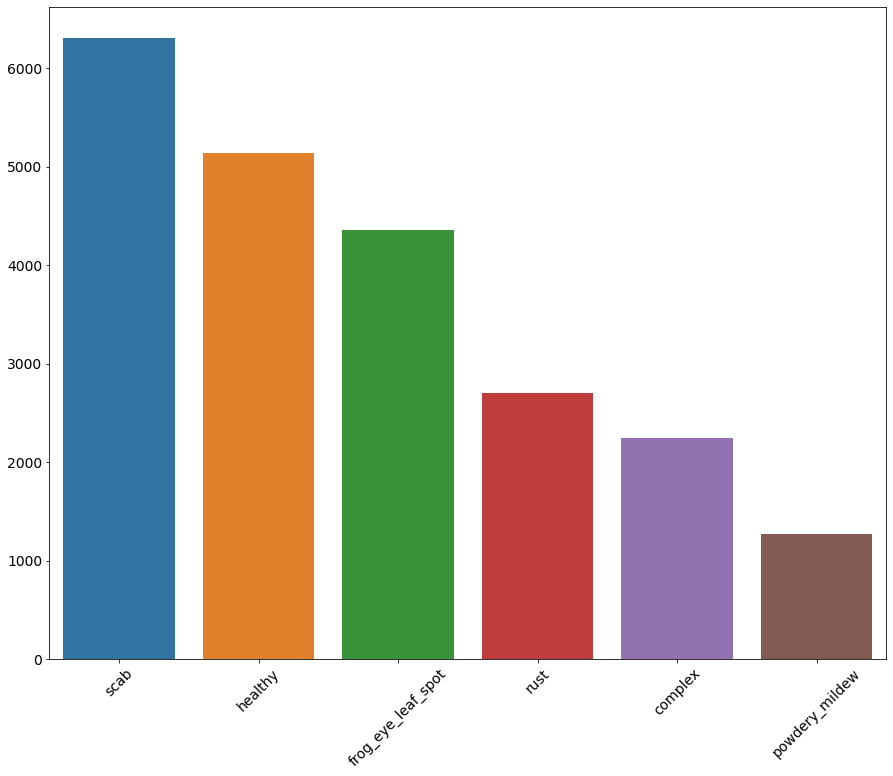

In [8]:
plt.rc('font', size=14) 
plt.figure(figsize=(15,12))
new_labels = sns.barplot(data=new_df,ci=None,estimator=sum)
for item in new_labels.get_xticklabels():
    item.set_rotation(45)

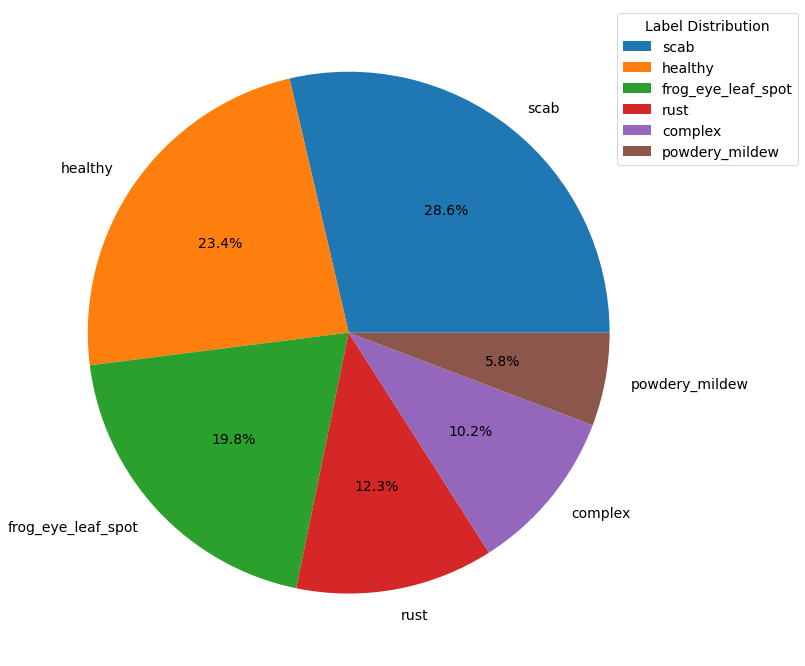

In [9]:
plt.figure(figsize=(15,12))
plt.pie(amount_of_labels ,autopct='%1.1f%%',labels=labels_list)#explode=(0.,0.,0.,0.,0.,0.,0.,0.9,0.9,0.9,0.9,0.9))
plt.legend(title = "Label Distribution",loc="upper right",bbox_to_anchor=(1.2,1))
plt.show() 


In [10]:
class PathologyPlantsDataset(Dataset):  #  <--- جنس پارامتر ورودی از نوع دیتاست برگرفته از کتابخانه دیتاست پایتورچ می باشد
  """
  The Class will act as the container for our dataset. It will take your dataframe, the root path, and also the transform function for transforming the dataset.
  """
  def __init__(self, data_frame, root_dir, transform=None):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform
    
  def __len__(self):
        # Return the length of the dataset
        return len(self.data_frame)
    
  def __getitem__(self, idx):
        # Return the observation based on an index. Ex. dataset[0] will return the first element from the dataset, in this case the image and the label.
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name)
        #label = int(self.data_frame.iloc[idx, 2])
        label = np.array(self.data_frame.iloc[idx, 1:].astype(int))
        
        if self.transform:
            image = self.transform(image)
    
        return (image, label)

In [11]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),
                                #transforms.ColorJitter(brightness=0.1, hue=.1),
                                #transforms.RandomAdjustSharpness(sharpness_factor=1),
                                #transforms.RandomPerspective(distortion_scale=0.3,p=0.2),
                                #transforms.RandomRotation(degrees=(0,180)),
                                #transforms.RandomAffine(),
                                #transforms.RandomResizedCrop(size=(224,224)),
                                transforms.Resize(size=(400,400)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                ])
pathology_train = PathologyPlantsDataset(data_frame=new_df,root_dir=train_image_path,transform=transform)
print(pathology_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


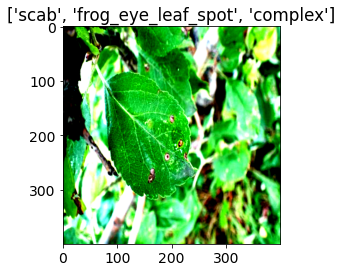

In [12]:
temp_img, temp_label = pathology_train[1]
plt.imshow(temp_img.numpy().transpose((1, 2, 0)))
x = np.where(temp_label==1)
plt.title([labels_list[i] for i in x[0]])   #x[0] chon 2 ta array barmigardoone va ma avalish ro mikhaim
#plt.title(temp_lab)
#plt.axis('off')
plt.show()

In [13]:
batch_size = 20   #  <------------------
split_ratio = 0.8
train_size = int(len(pathology_train)*split_ratio)
validation_size = len(pathology_train) - train_size
#sampler_weight = 1/source
#sampler = WeightedRandomSampler(sampler_weight, train_size)

train_dataset, valid_dataset = random_split(pathology_train, [train_size, validation_size] )
#load the train and validation into batches.
#train_dl = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, sampler = sampler, pin_memory = True)  # , pin_memory = True num_workers = 1, shuffle = True
train_dl = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, pin_memory = True)  # , pin_memory = True num_workers = 1, shuffle = True
val_dl = DataLoader(valid_dataset, batch_size = batch_size, shuffle = True, pin_memory = True)  # , pin_memory = True num_workers = 1, shuffle = True

print(f"Length of Dataset : {len(pathology_train)}")
print(f"Length of Train Data : {len(train_dataset)}")
print(f"Length of Validation Data : {len(valid_dataset)}")

Length of Dataset : 20453
Length of Train Data : 16362
Length of Validation Data : 4091


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


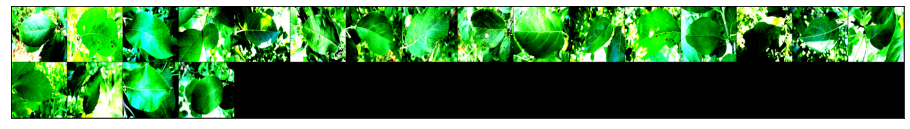

In [14]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

  
show_batch(train_dl)

In [15]:
targets_size=6
model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights)

for param in model.parameters():
            param.requires_grad = True
print(model)
model.fc = nn.Linear(2048, targets_size)
#model.classifier.add_module(nn.Sigmoid()) 
#model.AuxLogits.fc = nn.Linear(768, targets_size)     #Auxilary layer: For Inception_v3
print(model.fc)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
device = "cuda"
model.to(device)

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [17]:
#criterion = nn.MultiLabelSoftMarginLoss()
criterion =  nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [18]:
train_losses = []
validation_losses = []

In [19]:
prev_loss = 0.100

In [20]:

classes=torch.tensor([[1,0,0,0,0,0], # scab
                      [0,1,0,0,0,0], # healthy
                      [0,0,1,0,0,0], # frog_eye_leaf_spot
                      [0,0,0,1,0,0], # rust
                      [0,0,0,0,1,0], # complex
                      [0,0,0,0,0,1], # powdery_mildew
                      [1,0,1,0,0,0], # scab , frog_eye_leaf_spot
                      [1,0,1,0,1,0], # scab , frog_eye_leaf_spot , complex
                      [0,0,1,0,1,0], # frog_eye_leaf_spot , complex
                      [0,0,1,1,0,0], # frog_eye_leaf_spot , rust
                      [0,0,0,1,1,0], # complex , rust
                      [0,0,0,0,1,1]] # complex , powdery_mildew
                      ,dtype = torch.int64)

print(classes)
classes = classes.tolist()

tensor([[1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 1, 0, 1, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 1, 1]])


In [21]:
labels = ['scab','healthy','frog_eye_leaf_spot','rust','complex','powdery_mildew','scab frog_eye_leaf_spot','scab frog_eye_leaf_spot complex','frog_eye_leaf_spot complex','frog_eye_leaf_spot rust','complex rust','complex powdery_mildew']

In [22]:
def batch_gd(model, criterion, train_loader, validation_loader, epochs):
       
    global prev_loss
    global train_cm
    global validation_cm
    #weights.to(device)
    for e in range(epochs):
        t0 = datetime.now()
        train_n_correct = 0
        train_n_total = 0
        validation_n_correct = 0
        validation_n_total = 0
        train_cm = torch.zeros(12,2,dtype=torch.int64)
        validation_cm = torch.zeros(12,2,dtype=torch.int64)
        
        train_loss = []
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            #output, aux_output = model(inputs)  #for Inception_v3
            #loss1 = criterion(output, targets)      #for Inception_v3
            #loss2 = criterion(aux_output, targets)     #for Inception_v3
            #loss = loss1 + 0.4*loss2   #for Inception_v3
            output = model(inputs)
            #print(output)
            #print(targets)
            #output, targets = output.to('cpu'), targets.to('cpu')   # for getting errors on cpu

            loss = criterion(output, targets.type(torch.float)) 
            train_loss.append(loss.item())
            
            predictions = np.array(output.cpu().detach().numpy() > -0.2, dtype=int)
            predictions = predictions.tolist()
            targets = targets.tolist()
            
            
            #print("predictions: ",predictions)
            #print("targets:     ",targets)
            for i in range(len(targets)):
                class_number = classes.index(targets[i])
                if predictions[i] == targets[i]:
                    train_cm[class_number][0] += 1
                else:
                    train_cm[class_number][1] += 1
            
            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)
        train_accuracy = train_cm[:,0].sum()/len(train_dataset)
        

        validation_loss = []
        model.eval()
        with torch.no_grad():
          for inputs, targets in validation_loader:

            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)
            #output, aux_output = model(inputs)  #for Inception_v3 
            loss = criterion(output, targets.type(torch.float))
            validation_loss.append(loss.item())

            predictions = np.array(output.cpu().detach().numpy() > -0.2, dtype=int)
            predictions = predictions.tolist()
            targets = targets.tolist()

            #print("predictions: ",predictions)
            #print("targets:     ",targets)
            for i in range(len(targets)):
                class_number = classes.index(targets[i])
                if predictions[i] == targets[i]:
                    validation_cm[class_number][0] += 1
                else:
                    validation_cm[class_number][1] += 1

        validation_loss = np.mean(validation_loss)
        validation_accuracy = validation_cm[:,0].sum()/len(valid_dataset)
        
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        dt = datetime.now() - t0
        print('----------------------------------------------------------------------------------------')
        print(f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Validation_loss:{validation_loss:.3f} Duration:{dt} Train_Acc:{train_accuracy*100:.2f} Validation_Acc:{validation_accuracy*100:.2f}")
        print(train_cm)
        print("class ac",end=" : ")
        class_accuracy_train = train_cm[:,0]/train_cm.sum(dim=1)*100
        print(class_accuracy_train)
        print(validation_cm)
        print("class ac",end=" : ")
        class_accuracy_validation = validation_cm[:,0]/validation_cm.sum(dim=1)*100
        print(class_accuracy_validation)
        if validation_loss < prev_loss:
          prev_loss = validation_loss
          if select_machine == 2 : #colab
            os.chdir('/content/drive/MyDrive') 
          if select_machine == 3 : #kaggle
            os.chdir('/kaggle/working')  
          if select_machine == 1 : #local
            os.chdir('C:/Local Machine/plant-pathology-2020-fgvc-resized-combined/saves')
          torch.save(model, 'resnext50_multi-02.pt')
          torch.save(train_dl , 'resnext50_multi-02_train.pth')
          torch.save(val_dl , 'resnext50_multi-02_validation.pth')
          print("model saved !")
          
    return train_losses, validation_losses

In [23]:
train_losses, validation_losses = batch_gd(model, criterion, train_dl, val_dl, 1)

----------------------------------------------------------------------------------------
Epoch : 1/1 Train_loss:0.154 Validation_loss:0.108 Duration:0:09:47.826484 Train_Acc:76.63 Validation_Acc:83.89
tensor([[3760,  594],
        [3729,  359],
        [2149,  393],
        [1663,  314],
        [ 416,  952],
        [ 741,  211],
        [  30,  508],
        [   8,  155],
        [  28,  105],
        [   2,   96],
        [   5,   78],
        [   7,   59]])
class ac : tensor([86.3574, 91.2182, 84.5397, 84.1173, 30.4094, 77.8361,  5.5762,  4.9080,
        21.0526,  2.0408,  6.0241, 10.6061])
tensor([[ 974,   90],
        [1032,   20],
        [ 570,   69],
        [ 481,   24],
        [ 118,  207],
        [ 208,   24],
        [  32,  116],
        [   4,   33],
        [   8,   24],
        [   0,   22],
        [   1,   13],
        [   4,   17]])
class ac : tensor([91.5414, 98.0989, 89.2019, 95.2475, 36.3077, 89.6552, 21.6216, 10.8108,
        25.0000,  0.0000,  7.1429, 19.0476

In [24]:
train_losses, validation_losses = batch_gd(model, criterion, train_dl, val_dl, 10)

----------------------------------------------------------------------------------------
Epoch : 1/10 Train_loss:0.120 Validation_loss:0.105 Duration:0:09:07.688708 Train_Acc:81.66 Validation_Acc:85.11
tensor([[3988,  366],
        [3862,  226],
        [2256,  286],
        [1790,  187],
        [ 496,  872],
        [ 835,  117],
        [  54,  484],
        [  10,  153],
        [  35,   98],
        [   5,   93],
        [  19,   64],
        [  11,   55]])
class ac : tensor([91.5939, 94.4716, 88.7490, 90.5412, 36.2573, 87.7101, 10.0372,  6.1350,
        26.3158,  5.1020, 22.8916, 16.6667])
tensor([[ 987,   77],
        [1032,   20],
        [ 602,   37],
        [ 474,   31],
        [ 127,  198],
        [ 196,   36],
        [  46,  102],
        [   5,   32],
        [   5,   27],
        [   0,   22],
        [   3,   11],
        [   5,   16]])
class ac : tensor([92.7632, 98.0989, 94.2097, 93.8614, 39.0769, 84.4828, 31.0811, 13.5135,
        15.6250,  0.0000, 21.4286, 23.809

In [25]:
train_losses, validation_losses = batch_gd(model, criterion, train_dl, val_dl, 5)

----------------------------------------------------------------------------------------
Epoch : 1/5 Train_loss:0.069 Validation_loss:0.092 Duration:0:08:54.210388 Train_Acc:88.43 Validation_Acc:87.48
tensor([[4183,  171],
        [3998,   90],
        [2413,  129],
        [1841,  136],
        [ 802,  566],
        [ 901,   51],
        [ 192,  346],
        [  38,  125],
        [  39,   94],
        [   5,   93],
        [  28,   55],
        [  29,   37]])
class ac : tensor([96.0726, 97.7984, 94.9253, 93.1209, 58.6257, 94.6429, 35.6877, 23.3129,
        29.3233,  5.1020, 33.7349, 43.9394])
tensor([[1013,   51],
        [1030,   22],
        [ 587,   52],
        [ 486,   19],
        [ 186,  139],
        [ 224,    8],
        [  23,  125],
        [   6,   31],
        [  16,   16],
        [   0,   22],
        [   4,   10],
        [   4,   17]])
class ac : tensor([95.2068, 97.9087, 91.8623, 96.2376, 57.2308, 96.5517, 15.5405, 16.2162,
        50.0000,  0.0000, 28.5714, 19.0476

In [26]:
train_losses, validation_losses = batch_gd(model, criterion, train_dl, val_dl, 4)

----------------------------------------------------------------------------------------
Epoch : 1/4 Train_loss:0.056 Validation_loss:0.096 Duration:0:08:54.807075 Train_Acc:90.82 Validation_Acc:87.09
tensor([[4224,  130],
        [4022,   66],
        [2433,  109],
        [1869,  108],
        [ 941,  427],
        [ 907,   45],
        [ 267,  271],
        [  56,  107],
        [  48,   85],
        [  17,   81],
        [  38,   45],
        [  38,   28]])
class ac : tensor([97.0142, 98.3855, 95.7120, 94.5372, 68.7866, 95.2731, 49.6283, 34.3558,
        36.0902, 17.3469, 45.7831, 57.5758])
tensor([[1015,   49],
        [1040,   12],
        [ 561,   78],
        [ 471,   34],
        [ 154,  171],
        [ 214,   18],
        [  79,   69],
        [   8,   29],
        [   5,   27],
        [   0,   22],
        [   3,   11],
        [  13,    8]])
class ac : tensor([95.3947, 98.8593, 87.7934, 93.2673, 47.3846, 92.2414, 53.3784, 21.6216,
        15.6250,  0.0000, 21.4286, 61.9048

In [27]:
train_losses, validation_losses = batch_gd(model, criterion, train_dl, val_dl, 5)

----------------------------------------------------------------------------------------
Epoch : 1/5 Train_loss:0.044 Validation_loss:0.097 Duration:0:08:53.413390 Train_Acc:92.56 Validation_Acc:88.39
tensor([[4238,  116],
        [4042,   46],
        [2448,   94],
        [1872,  105],
        [1047,  321],
        [ 924,   28],
        [ 340,  198],
        [  60,  103],
        [  55,   78],
        [  27,   71],
        [  51,   32],
        [  41,   25]])
class ac : tensor([97.3358, 98.8748, 96.3021, 94.6889, 76.5351, 97.0588, 63.1970, 36.8098,
        41.3534, 27.5510, 61.4458, 62.1212])
tensor([[ 996,   68],
        [1029,   23],
        [ 604,   35],
        [ 482,   23],
        [ 191,  134],
        [ 226,    6],
        [  50,   98],
        [  13,   24],
        [   7,   25],
        [   2,   20],
        [   5,    9],
        [  11,   10]])
class ac : tensor([93.6090, 97.8137, 94.5227, 95.4455, 58.7692, 97.4138, 33.7838, 35.1351,
        21.8750,  9.0909, 35.7143, 52.3810

In [28]:
train_losses, validation_losses = batch_gd(model, criterion, train_dl, val_dl, 5)

----------------------------------------------------------------------------------------
Epoch : 1/5 Train_loss:0.032 Validation_loss:0.126 Duration:0:08:54.363384 Train_Acc:94.16 Validation_Acc:87.73
tensor([[4269,   85],
        [4047,   41],
        [2472,   70],
        [1891,   86],
        [1132,  236],
        [ 913,   39],
        [ 393,  145],
        [  85,   78],
        [  59,   74],
        [  42,   56],
        [  49,   34],
        [  55,   11]])
class ac : tensor([98.0478, 98.9971, 97.2463, 95.6500, 82.7485, 95.9034, 73.0483, 52.1472,
        44.3609, 42.8571, 59.0361, 83.3333])
tensor([[1018,   46],
        [1034,   18],
        [ 580,   59],
        [ 460,   45],
        [ 236,   89],
        [ 210,   22],
        [  24,  124],
        [   3,   34],
        [   9,   23],
        [   0,   22],
        [   5,    9],
        [  10,   11]])
class ac : tensor([95.6767, 98.2890, 90.7668, 91.0891, 72.6154, 90.5172, 16.2162,  8.1081,
        28.1250,  0.0000, 35.7143, 47.6190

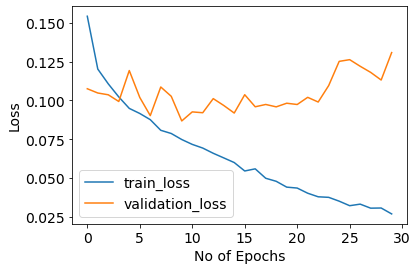

In [29]:
plt.plot(train_losses , label = 'train_loss')
plt.plot(validation_losses , label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
tensor([[4281,   73],
        [4058,   30],
        [2489,   53],
        [1905,   72],
        [1186,  182],
        [ 935,   17],
        [ 434,  104],
        [  80,   83],
        [  71,   62],
        [  59,   39],
        [  58,   25],
        [  55,   11]])


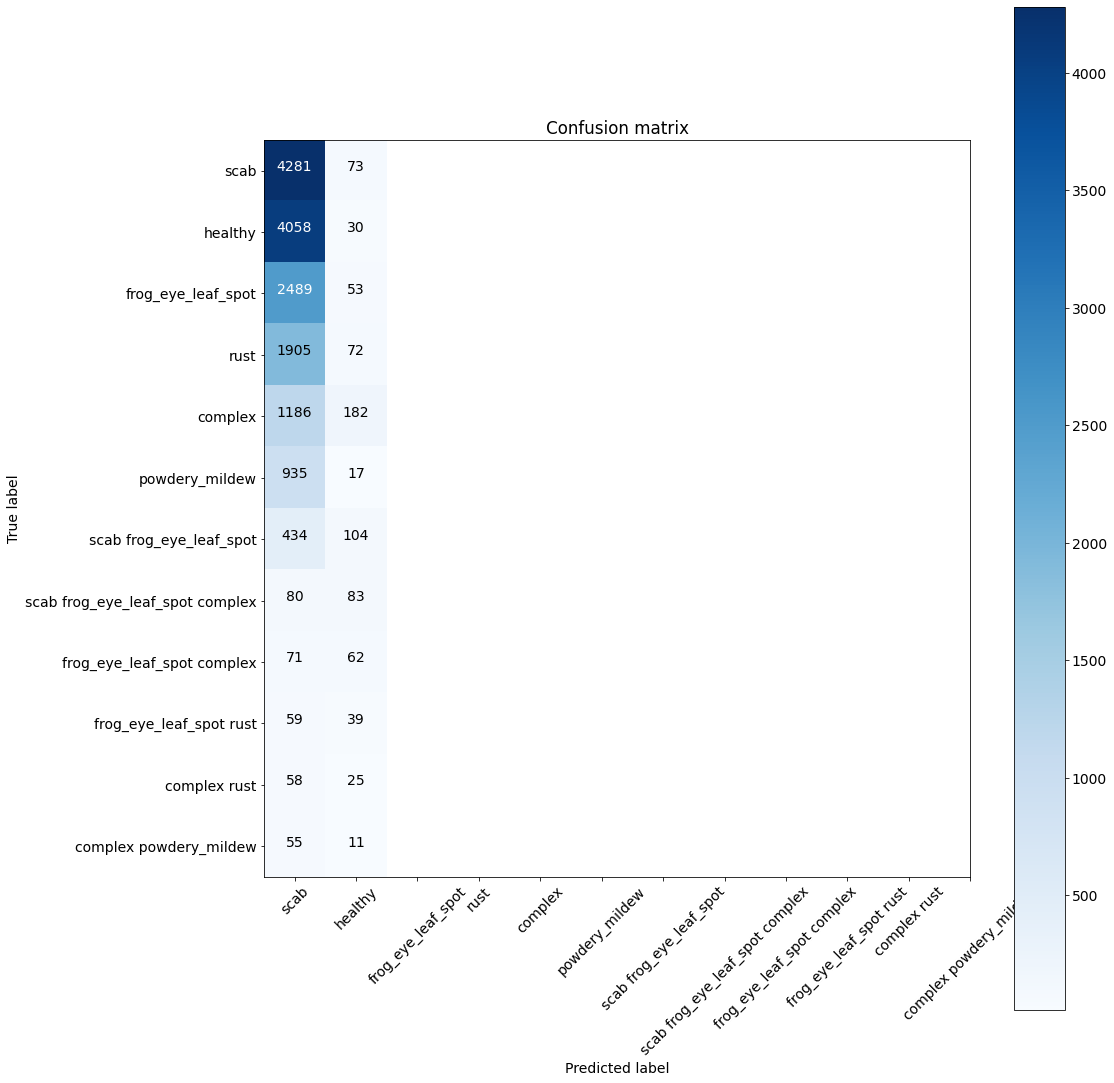

In [31]:
plt.figure(figsize=(16,16))
plot_confusion_matrix(train_cm, labels)

Confusion matrix, without normalization
tensor([[1000,   64],
        [1028,   24],
        [ 556,   83],
        [ 467,   38],
        [ 214,  111],
        [ 227,    5],
        [  33,  115],
        [   7,   30],
        [   7,   25],
        [   0,   22],
        [   7,    7],
        [  10,   11]])


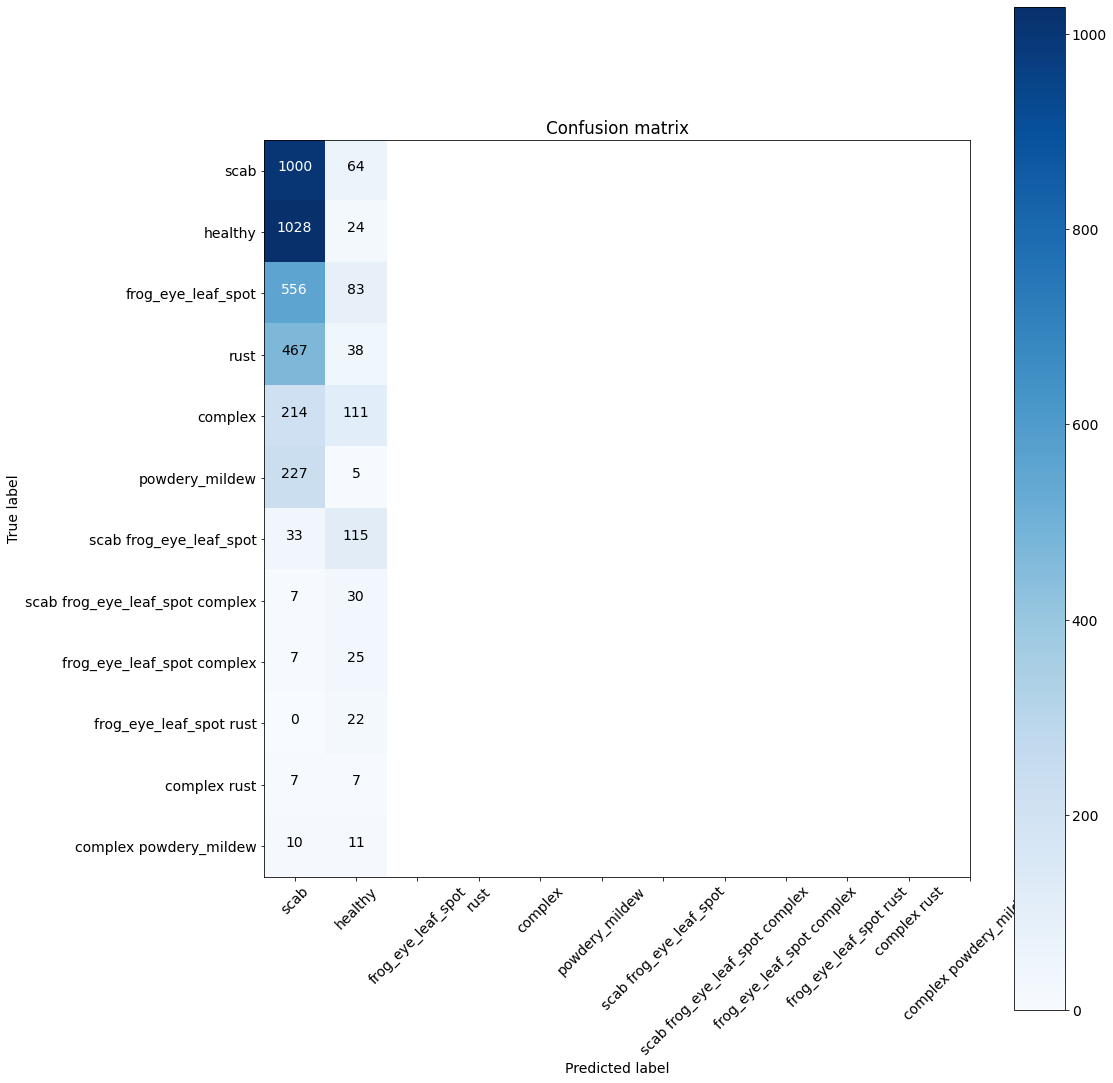

In [32]:
plt.figure(figsize=(16,16))
plot_confusion_matrix(validation_cm, labels)

# **Save Model, Data Loaders**

In [33]:
if select_machine == 1: os.chdir('C:/Local Machine/plant-pathology-2020-fgvc-resized-combined/saves')   #local
if select_machine == 2: os.chdir('/content/drive/MyDrive')   #colab
if select_machine == 3: os.chdir('/kaggle/working')   #kaggle
torch.save(model, 'resnext50_multi-02_2.pt')
#torch.save(train_dl , 'mobilenetv3l_multi_train_2.pth')
#torch.save(val_dl , 'mobilenetv3l_multi_validation_2.pth')

# **Load Model, Data Loaders**

In [ ]:
if select_machine == 1: os.chdir('C:/Local Machine/plant-pathology-2021-fgvc8-resized/saves')   #local
if select_machine == 2: os.chdir('/content/drive/MyDrive')   #colab
if select_machine == 3: os.chdir('/kaggle/working')   #kaggle
targets_size = 12
#model.load_state_dict(torch.load("plant_disease_model_6.pt"))
model=torch.load('plant_disease_model_6.pt')
train_dl = torch.load("train_dl6.pth")
val_dl = torch.load("val_dl6.pth")
print(model)